In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [5]:
import torch
from pathlib import Path

In [7]:
# 1. load the COCO-pretrained YOLOv5s
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /home/kmatsuda/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-20 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3090, 24250MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


## Important: This is needed after loading yolo v5
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

under the hood it pulls in a bunch of native libs (OpenCV, threading hooks, etc.) that can inadvertently switch off the Jupyter “inline” display backend. The fix is simply to re-enable the inline backend (or interactive mode) after you load the model. For example:

```
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
plt.ion()
```

In [8]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
plt.ion()

In [10]:
soccer_path = Path('../pressure')
soccer_images = list(soccer_path.glob('*.png'))
imgs = [path.as_posix() for path in soccer_images]

In [11]:
# 2. inference
results = model(imgs)   # replace with your files

/home/kmatsuda/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [12]:
# 3. render to get annotated BGR arrays
rendered = results.render()

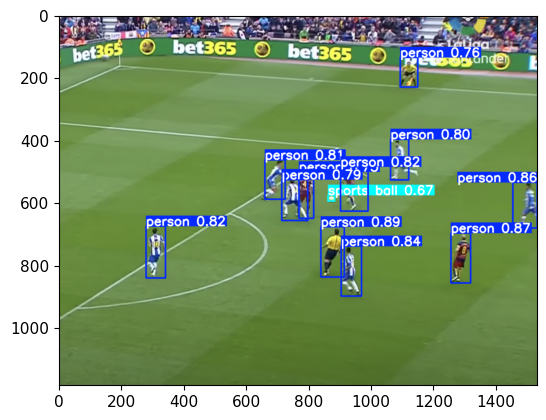

In [13]:
plt.imshow(rendered[0])

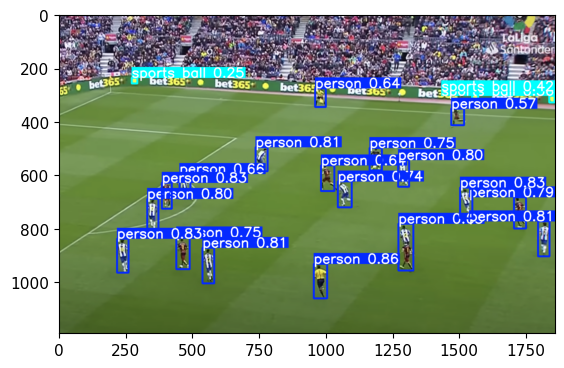

In [14]:
plt.imshow(rendered[1])

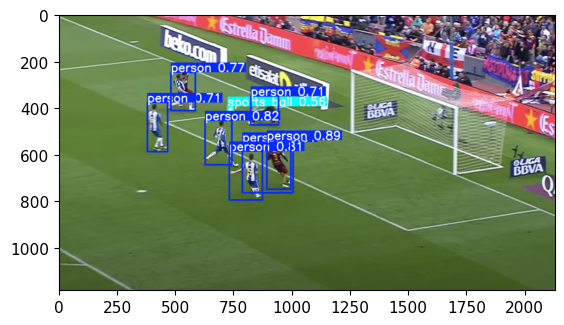

In [15]:
plt.imshow(rendered[2])